In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as mpl
from sklearn.cluster import DBSCAN
import pandas as pd

#— User parameters (edit these directly) —
FILE_PATH = "05mm-300W+1200FS-skip08.xlsx"    # path to your three-column x y z file
L = 150.0                                     # threshold value for z

# 1) Load data
df = pd.read_excel(FILE_PATH)
df.columns = df.columns.str.strip().str.lower()
x = df['x'].values
y = df['y'].values
z = df['z'].values
#data = np.loadtxt(FILE_PATH)
#x, y, z = data[:,0], data[:,1], data[:,2]
N = len(z)
print(str(N)+" data points")

438750 data points


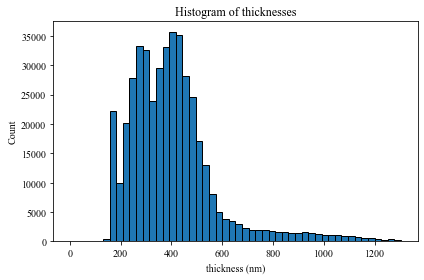

In [2]:
# 2) Histogram & cumulative distribution of z
n_bins = 50
hist, bins = np.histogram(z, bins=n_bins)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Save histogram
np.savetxt("histo.txt",
np.column_stack((bin_centers, hist)),
header="thickness count", comments='')

# Compute & save cumulative distribution
cum_counts = np.cumsum(hist)
cum_dist   = cum_counts / cum_counts[-1]
np.savetxt("cumulative.txt",
           np.column_stack((bin_centers, cum_dist)),
           header="thickness cumulative_prob", comments='')

# Plot histogram of z
#mpl.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(6,4))
plt.bar(bin_centers, hist,
            width=(bins[1]-bins[0]),
            color='C0', edgecolor='black')
plt.xlabel("thickness (nm)")
plt.ylabel("Count")
plt.title("Histogram of thicknesses")
plt.tight_layout()
plt.savefig("Thickesses_Histogram.tiff", dpi=300)
plt.show()

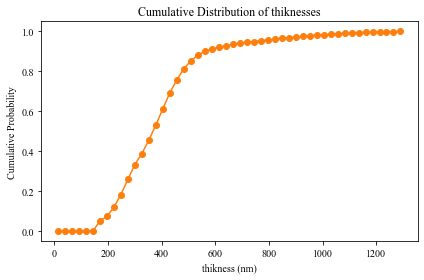

In [3]:
# Plot cumulative distribution of z
plt.figure(figsize=(6,4))
plt.plot(bin_centers, cum_dist,
             marker='o', color='C1')
plt.xlabel("thikness (nm)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of thiknesses")
plt.tight_layout()
plt.savefig("Thickesses_Cumulative.tiff", dpi=300)
plt.show()

Points with z ≤ 150.0: 499 of 438750
Number of clusters found: 9


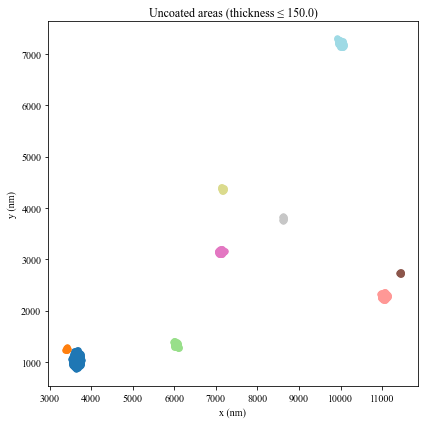

In [4]:
# 3) Threshold and extract (x,y)
mask  = (z <= L)
coords = np.column_stack((x[mask], y[mask]))
print(f"Points with z ≤ {L}: {coords.shape[0]} of {N}")

# 4) Cluster low-z points with DBSCAN
db     = DBSCAN(eps=30.0, min_samples=5)
labels = db.fit_predict(coords)
# only true clusters, drop noise=-1
unique_labels = sorted(l for l in set(labels) if l != -1)
#unique_labels = sorted(set(labels))
n_labels = len(unique_labels)
cmap = plt.cm.get_cmap("tab20", n_labels)  # “tab20” has up to 20 distinct colors
# Print number of clusters (excluding noise label = –1)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
print(f"Number of clusters found: {n_clusters}")

plt.figure(figsize=(6,6))
for idx, lbl in enumerate(unique_labels):
    pts = coords[labels == lbl]
    color = cmap(idx)
    lbl_name = "noise" if lbl == -1 else f"cluster {lbl}"
    plt.scatter(pts[:,0], pts[:,1],
                c=[color], s=30,
               label=lbl_name)
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.title(f"Uncoated areas (thickness ≤ {L})")
plt.tight_layout()
plt.savefig("Uncoated_areas.tiff", dpi=300)
plt.show()

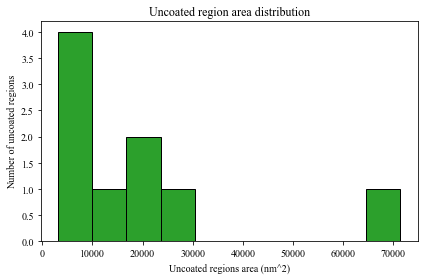

In [5]:
# 5) Compute area factor A and cluster fractions
A = (np.max(x)-np.min(x)) * (np.max(y)-np.min(y))
frac_vals = []
for lbl in unique_labels:
    if lbl == -1:
        continue
    size = np.sum(labels == lbl)
    frac_vals.append((size / N) * A)
frac_vals = np.array(frac_vals)

# Histogram of (cluster_size/N) * A
nb = 10
f_hist, f_bins = np.histogram(frac_vals, bins=nb)
f_centers = (f_bins[:-1] + f_bins[1:]) / 2

# Save voids histogram
np.savetxt("uncoated.txt",
           np.column_stack((f_centers, f_hist)),
           header="(Uncoated area count", comments='')

# Plot voids histogram
plt.figure(figsize=(6,4))
plt.bar(f_centers, f_hist,
        width=(f_bins[1]-f_bins[0]),
        color='C2', edgecolor='black')
plt.xlabel("Uncoated regions area (nm^2)")
plt.ylabel("Number of uncoated regions")
plt.title("Uncoated region area distribution")
plt.tight_layout()
plt.savefig("Uncoated_areas_histogram.tiff", dpi=300)
plt.show()